# Homework: Basic Artificial Neural Networks

The goal of this homework is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design of was heavily inspired by [Torch](http://torch.ch) which is the most convenient neural network environment when the work involves defining new layers. 

This homework requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- homework_modules.ipynb
- homework_differentiation.ipynb

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `Modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [2]:
# (re-)load layers
%run homework_modules.ipynb

Optimizer is implemented for you. 

In [3]:
def sgd_momentum(x, dx, config, state):
    """
        This is a very ugly implementation of sgd with momentum 
        just to show an example how to store old grad in state.
        
        config:
            - momentum
            - learning_rate
        state:
            - old_grad
    """
    
    # x and dx have complex structure, old dx will be stored in a simpler one
    state.setdefault('old_grad', {})
    
    i = 0 
    for cur_layer_x, cur_layer_dx in zip(x,dx): 
        for cur_x, cur_dx in zip(cur_layer_x,cur_layer_dx):
            
            cur_old_grad = state['old_grad'].setdefault(i, np.zeros_like(cur_dx))
            
            np.add(config['momentum'] * cur_old_grad, config['learning_rate'] * cur_dx, out = cur_old_grad)
            
            cur_x -= cur_old_grad
            i += 1     

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

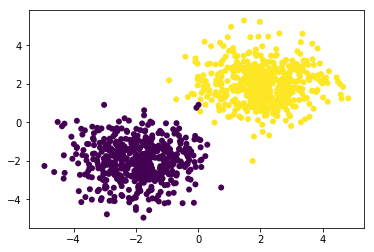

In [4]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [5]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

net = Sequential()
net.add(Linear(2, 4))
net.add(ReLU())
net.add(Linear(4, 2))
net.add(LogSoftMax())
print(net)

Linear 2 -> 2
LogSoftMax

Linear 2 -> 4
ReLU
Linear 4 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [6]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [7]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

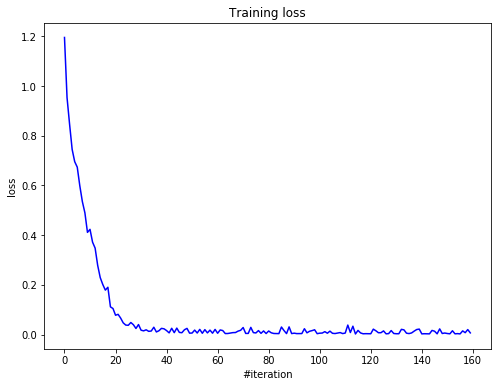

Current loss: 0.006586


In [8]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. Lets start with [cool visualization](http://scs.ryerson.ca/~aharley/vis/). The most beautiful demo is the second one, if you are not familiar with convolutions you can return to it in several lectures. 

In [9]:
import os
from sklearn.datasets import fetch_mldata

# Fetch MNIST dataset and create a local copy.
if os.path.exists('mnist.npz'):
    with np.load('mnist.npz', 'r') as data:
        X = data['X']
        y = data['y']
else:
    mnist = fetch_mldata("mnist-original")
    X, y = mnist.data / 255.0, mnist.target
    np.savez('mnist.npz', X=X, y=y)

One-hot encode the labels first.

In [10]:
# Your code goes here. ################################################
Y = np.zeros((y.shape[0], 10))
Y[range(y.shape[0]), y.astype(int)] = 1

In [11]:
from sklearn.metrics import accuracy_score
from collections import defaultdict

In [12]:
#from  sklearn.preprocessing import LabelBinarizer
#from sklearn.metrics import accuracy_score
#binarizer = LabelBinarizer()
#Y = binarizer.fit_transform(y)

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Hint: logloss for MNIST should be around 0.5. 

In [13]:
X.shape

(70000, 784)

In [14]:
# Your code goes here. ################################################
# ReLU
net = Sequential()
net.add(Linear(784, 300))
net.add(ReLU())
net.add(Linear(300, 100))
net.add(ReLU())
net.add(Linear(100, 10))
net.add(LogSoftMax())
print(net)

Linear 784 -> 300
ReLU
Linear 300 -> 100
ReLU
Linear 100 -> 10
LogSoftMax



In [15]:
# Build net
def build_net(activation: Module, batch_norm: bool=False, batch_norm_alpha: float=0.9) -> Sequential:
    net = Sequential()
    net.add(Linear(784, 300))
    net.add(activation())
    if batch_norm:
        net.add(BatchNormalization(alpha=batch_norm_alpha))
        net.add(ChannelwiseScaling(300))
    net.add(Linear(300, 100))
    net.add(activation())
    if batch_norm:
        net.add(BatchNormalization(alpha=batch_norm_alpha))
        net.add(ChannelwiseScaling(100))
    net.add(Linear(100, 10))
    net.add(LogSoftMax())
    return net

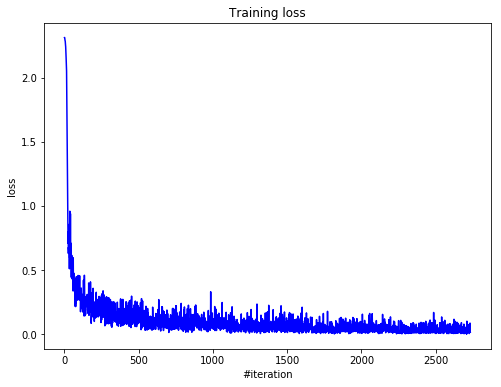

Current loss: 0.015282


In [16]:
net = build_net(ReLU, batch_norm=False)

loss_history = []
n_epoch = 5
batch_size = 128
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

criterion = ClassNLLCriterion()

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss) 

In [17]:
# Train net
def train(X, Y, net, criterion, optimizer_config, optimizer_state, n_epochs: int=5, batch_size: int=128):
    """
    Generator for handling neural networks training
    """
    # Switching net to training mode
    net.train()
    # Main training procedure
    for i in range(n_epochs):
        for x_batch, y_batch in get_batches((X, Y), batch_size):
            
            net.zeroGradParameters()

            # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            # Update weights
            sgd_momentum(net.getParameters(), 
                         net.getGradParameters(), 
                         optimizer_config,
                         optimizer_state)
            yield loss

In [18]:
# Visualise results
def visualize(experiments, log_scale: bool=False, print_last_loss=True):
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    if log_scale:
        plt.yscale('log')
    for experiment, loss_history in experiments.items():
        plt.plot(loss_history, label=experiment)
    plt.legend()
    plt.show()
    
    if print_last_loss:
        print("Losses: ")
        for experiment, loss_history in experiments.items():
            print(f"{experiment} loss: {loss_history[-1]}")

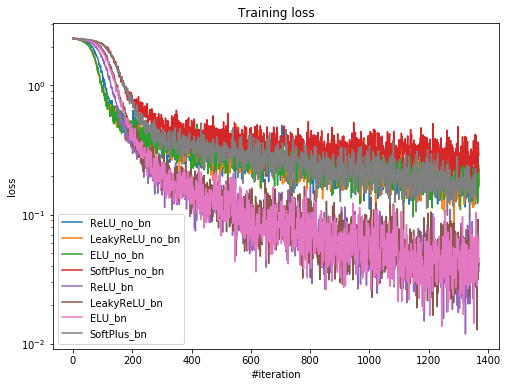

Losses: 
ReLU_no_bn loss: 0.22503257115719638
LeakyReLU_no_bn loss: 0.17551544247656253
ELU_no_bn loss: 0.16323499722163728
SoftPlus_no_bn loss: 0.28720285634558024
ReLU_bn loss: 0.03620825027874258
LeakyReLU_bn loss: 0.04062189689979334
ELU_bn loss: 0.06612861636111032
SoftPlus_bn loss: 0.12107107444121848


In [19]:
# Running experiments
use_bn = [False, True]
activation_fns = {
    'ReLU': ReLU, 
    'LeakyReLU': lambda: LeakyReLU(slope=0.03), 
    'ELU': lambda: ELU(alpha=0.01), 
    'SoftPlus': SoftPlus}
experiments = defaultdict(list)

for bn_flag in use_bn:
    for activation_name, activation_fn in activation_fns.items():
        label = f"{activation_name}_" + ("bn" if bn_flag else "no_bn")
        net = build_net(activation_fn, batch_norm=bn_flag)
        criterion = ClassNLLCriterion()
        train_generator = train(X, 
                                Y, 
                                n_epochs=5, 
                                batch_size=256, 
                                net=net, 
                                criterion=criterion,
                                optimizer_config={'learning_rate': 1e-2, 'momentum': 0.9}, 
                                optimizer_state={})
        for idx, loss in enumerate(train_generator):
            experiments[label].append(loss)
            if (idx + 1) % 20 == 0:
                visualize(experiments, log_scale=True)

In [20]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [21]:
experiments_a = {label: running_mean(np.array(loss), 25) for label, loss in experiments.items()}

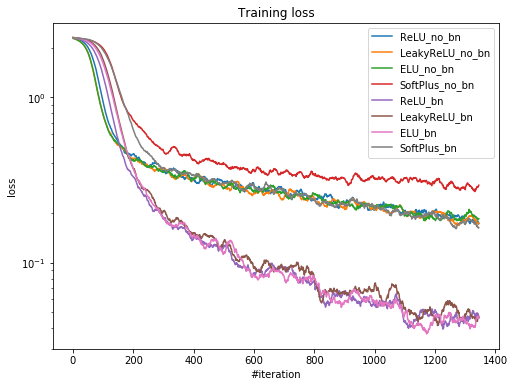

Losses: 
ReLU_no_bn loss: 0.17314711290889137
LeakyReLU_no_bn loss: 0.1732470990930915
ELU_no_bn loss: 0.1843557263373532
SoftPlus_no_bn loss: 0.2941033204096902
ReLU_bn loss: 0.04670994040584219
LeakyReLU_bn loss: 0.046139397619538156
ELU_bn loss: 0.047317443078936774
SoftPlus_bn loss: 0.16277488555163927


In [22]:
visualize(experiments_a, log_scale=True)

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

ReLU, LeakyReLU and ELU works pretty the same for this net, SoftPlus is bad compared to the other. Batchnorm gives huge improvement to the nets convergence.

**Finally**, use all your knowledge to build a super cool model on this dataset, do not forget to split dataset into train and validation. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [24]:
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.3, shuffle=True)

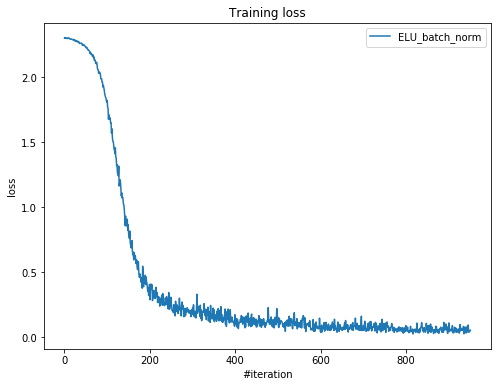

Losses: 
ELU_batch_norm loss: 0.055643104318840744


In [25]:
net = build_net(activation=lambda: ELU(alpha=0.01), batch_norm=True)
experiments = defaultdict(list)
criterion = ClassNLLCriterion()
train_generator = train(X_train, 
                        y_train, 
                        n_epochs=5, 
                        batch_size=256, 
                        net=net, 
                        criterion=criterion,
                        optimizer_config={'learning_rate': 1e-2, 'momentum': 0.9}, 
                        optimizer_state={})
label = 'ELU_batch_norm'
for idx, loss in enumerate(train_generator):
    experiments[label].append(loss)
    if idx % 50 == 0:
        visualize(experiments)

Print here your accuracy. It should be around 90%.

In [26]:
net.evaluate()
net.zeroGradParameters()
pred = net.forward(X_valid)
accuracy = accuracy_score(y_valid.argmax(axis=1), pred.argmax(axis=1))
print(f"Accuracy score: {accuracy}")

Accuracy score: 0.9730952380952381


# Autoencoder

Now we are going to build a cool model, named autoencoder. The aim is simple: **encode** the data to a lower dimentional representation. Why? Well, if we can **decode** this representation back to original data with "small" reconstuction loss then we can store only compressed representation saving memory. But the most important thing is -- we can reuse trained autoencoder for classification. 
<img src="autoencoder.png">

Picture from this [site](http://multithreaded.stitchfix.com/blog/2015/09/17/deep-style/).

Now implement an autoencoder:

Build it such that dimetionality inside autoencoder changes like that: 

$$784 \text{ (data)} -> 512 -> 256 -> 128 -> 30 -> 128 -> 256 -> 512 -> 784$$

Use `MSECriterion` to score the reconstruction. Use `BatchNormalization` (followed by `ChannelwiseScaling` as usual) between `Linear` and `ReLU`. You may not use nonlinearity in bottleneck layer.

You may train it for 9 epochs with batch size = 256, initial lr = 0.1 droping by a factor of 2 every 3 epochs. The reconstruction loss should be about 6.0 and visual quality decent already.
Do not spend time on changing architecture, they are more or less the same. 

In [97]:
class Sigmoid(Module):
    def __init__(self):
        super(Sigmoid, self).__init__()
    
    def updateOutput(self, input):
        # Your code goes here. ################################################
        self.output = 1. / (1. + np.exp(- input))
        return  self.output
    
    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        self.gradInput = gradOutput * self.output * (1. - self.output)
        return self.gradInput
    
    def __repr__(self):
        return "Sigmoid"

In [101]:
net = Sequential()

net.add(Linear(784, 512))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(512))
net.add(ReLU())

net.add(Linear(512, 256))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(256))
net.add(ReLU())

net.add(Linear(256, 128))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(128))
net.add(ReLU())

net.add(Linear(128, 30))

net.add(Linear(30, 128))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(128))
net.add(ReLU())

net.add(Linear(128, 256))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(256))
net.add(ReLU())

net.add(Linear(256, 512))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(512))
net.add(ReLU())

net.add(Linear(512, 784))
net.add(Sigmoid())

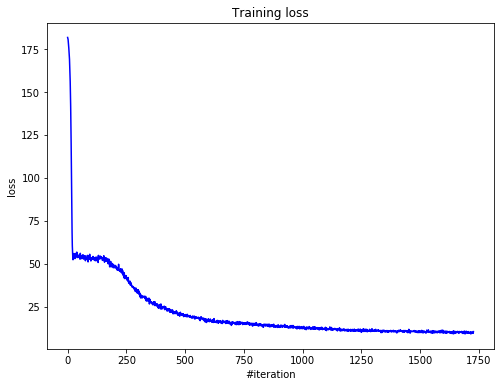

Current loss: 10.558009
Current learning rate 0.00125


In [102]:
loss_history = []
n_epoch = 9
batch_size = 256
optimizer_config = {'learning_rate' : 1e-2, 'momentum': 0.9}
optimizer_state = {}

criterion = MSECriterion()

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X_train, X_train), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)
        
    if i % 3 == 2:
        optimizer_config["learning_rate"] /= 2

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)
    print(f'Current learning rate {optimizer_config["learning_rate"]}')

Some time ago NNs were a lot poorer and people were struggling to learn deep models. To train a classification net people were training autoencoder first (to train autoencoder people were pretraining single layers with [RBM](https://en.wikipedia.org/wiki/Restricted_Boltzmann_machine)), then substituting the decoder part with classification layer (yeah, they were struggling with training autoencoders a lot, and complex techniques were used at that dark times). We are going to this now, fast and easy.  

In [29]:
# Extract inner representation for train and validation, 
# you should get (n_samples, 30) matrices
# Your code goes here. ################################################
encoder = Sequential()
l = len(net.modules)
for idx, module in enumerate(net.modules):
    if idx >= l // 2:
        break
    encoder.add(module)
print(encoder)

Linear 784 -> 512
BatchNormalization
ChannelwiseScaling
ReLU
Linear 512 -> 256
BatchNormalization
ChannelwiseScaling
ReLU
Linear 256 -> 128
BatchNormalization
ChannelwiseScaling
ReLU
Linear 128 -> 30



In [30]:
code_train = encoder.forward(X_train)
code_test = encoder.forward(X_valid)

In [31]:
code_train.shape, code_test.shape

((49000, 30), (21000, 30))

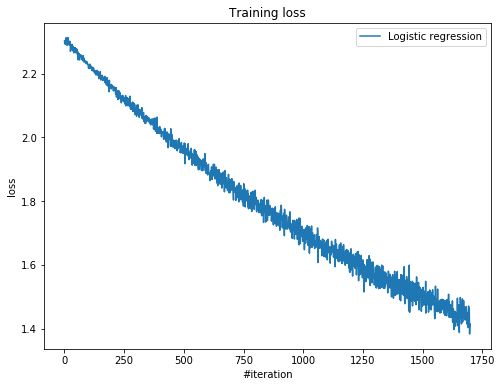

Losses: 
Logistic regression loss: 1.413666430266356
Accuracy score: 0.7922857142857143


In [40]:
# Now build a logistic regression or small classification net
cnet = Sequential()
cnet.add(Linear(30, 10))
cnet.add(LogSoftMax())

experiments = defaultdict(list)
criterion = ClassNLLCriterion()
train_generator = train(code_train, 
                        y_train, 
                        n_epochs=9, 
                        batch_size=256, 
                        net=cnet, 
                        criterion=criterion,
                        optimizer_config={'learning_rate': 1e-2, 'momentum': 0.9}, 
                        optimizer_state={})
label = 'Logistic regression'
for idx, loss in enumerate(train_generator):
    experiments[label].append(loss)
    if idx % 50 == 0:
        visualize(experiments)
# Evaluate on the test data
cnet.evaluate()
cnet.zeroGradParameters()
pred = cnet.forward(code_test)
accuracy = accuracy_score(y_valid.argmax(axis=1), pred.argmax(axis=1))
print(f"Accuracy score: {accuracy}")

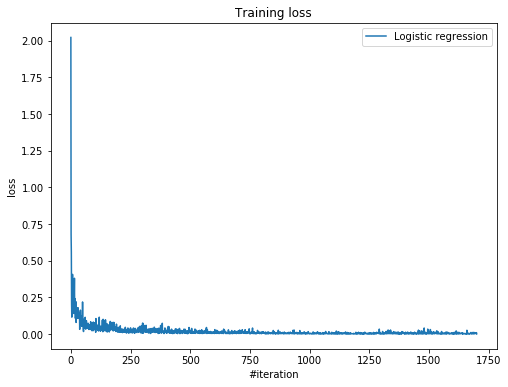

Losses: 
Logistic regression loss: 0.0015522077565182234
Accuracy score: 0.9769047619047619


In [41]:
# Build small logistic regressionnet
#cnet = Sequential()
#cnet.add(Linear(30, 10))
#cnet.add(LogSoftMax())

# Now chop off decoder part
# (you may need to implement `remove` method for Sequential container) 
autoenc = Sequential()
l = len(net.modules)
for idx, module in enumerate(net.modules):
    if idx >= l // 2:
        break
    autoenc.add(module)

# And add learned layers ontop.
autoenc.add(cnet[0])
autoenc.add(cnet[1])
print(autoenc)

# Now optimize whole model
# Your code goes here. ################################################
experiments = defaultdict(list)
criterion = ClassNLLCriterion()
train_generator = train(X_train, 
                        y_train, 
                        n_epochs=9, 
                        batch_size=256, 
                        net=autoenc, 
                        criterion=criterion,
                        optimizer_config={'learning_rate': 1e-2, 'momentum': 0.9}, 
                        optimizer_state={})
label = 'Logistic regression'
for idx, loss in enumerate(train_generator):
    experiments[label].append(loss)
    if idx % 50 == 0:
        visualize(experiments)
# Evaluate on the test data
autoenc.evaluate()
autoenc.zeroGradParameters()
pred = autoenc.forward(X_valid)
accuracy = accuracy_score(y_valid.argmax(axis=1), pred.argmax(axis=1))
print(f"Accuracy score: {accuracy}")

* What do you think, does it make sense to build real-world classifiers this way ? Did it work better for you than a straightforward one? Looks like it was not the same ~8 years ago, what has changed beside computational power? 

Results are comparable, we get approximately equal results. So now there is no need in pretraining autoencoders. New optimization methods were developed that boosted network training procedure. Also backprop plus computational power give us possibility to train deeper architectures than it was some time ago.

Run PCA with 30 components on the *train set*, plot original image, autoencoder and PCA reconstructions side by side for 10 samples from *validation set*.
Probably you need to use the following snippet to make aoutpencoder examples look comparible.

In [42]:
from sklearn.decomposition import PCA

In [103]:
# np.clip(prediction,0,1)
#
# PCA encoder training
pca_enc = PCA(n_components=30)
pca_enc.fit(X_train)
pca_code = pca_enc.transform(X_valid)

In [104]:
reconstr_aue[0].max()

1.1412756092219327

In [105]:
images_idx = np.random.choice(len(X_valid), size=10)

In [106]:
# Acquire reconstructed images
net.evaluate()
reconstr_aue = net.forward(X_train[images_idx]).reshape(10, 28, 28)
reconstr_pca = pca_enc.inverse_transform(pca_code)[images_idx].reshape(10, 28, 28)

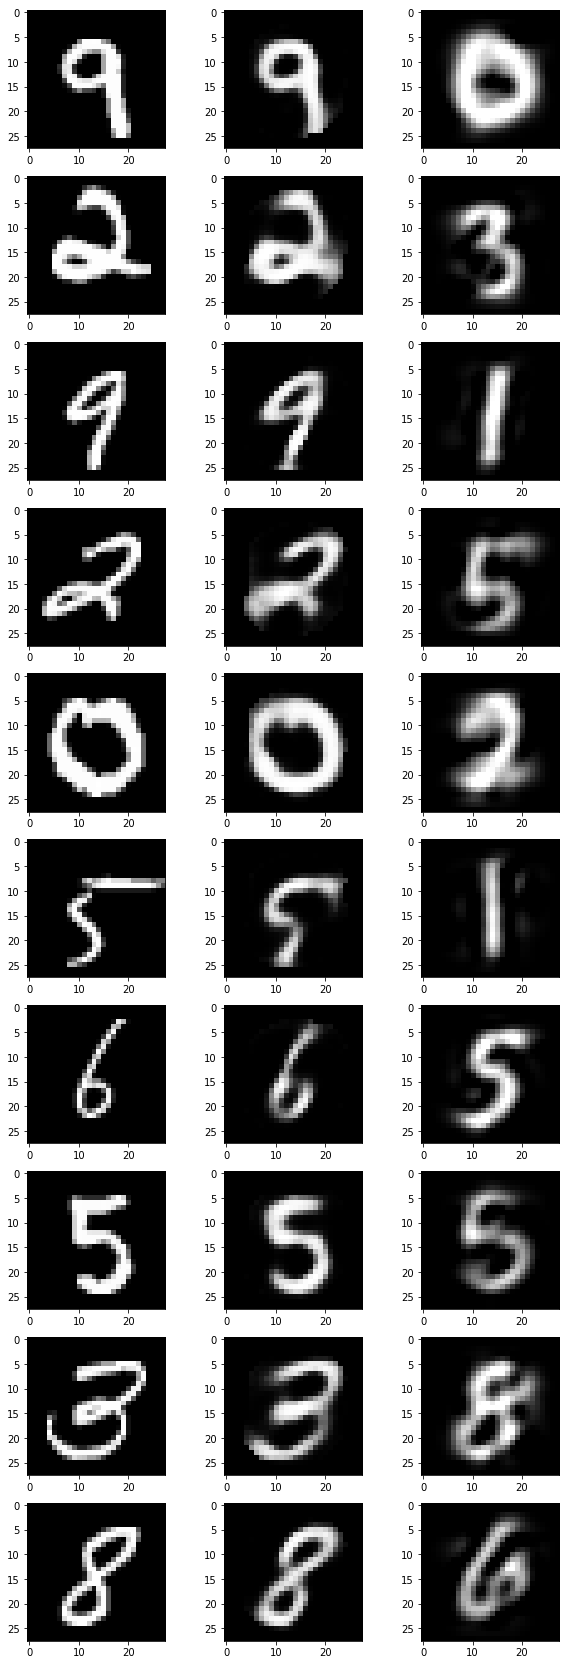

In [107]:
fig, ax = plt.subplots(nrows=10, ncols=3, figsize=(10,30))
for idx, (orig_img, aue_img, pca_img) in enumerate(zip(X_train[images_idx], reconstr_aue, reconstr_pca)):
    ax[idx][0].imshow(orig_img.reshape(28, 28), cmap='gray')
    ax[idx][1].imshow(np.clip(aue_img, 0, 1), cmap='gray')
    ax[idx][2].imshow(np.clip(pca_img, 0, 1), cmap='gray')
plt.show()

Autoencoder seems to work better than PCA that is more inclined to reconstructing wrong numbers, e.g. zero -> nine, eight -> five. Autoencoder acquires better latent code of the images.